# Ground-roll 2D attenuation model with trace permutation

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Hyperparameters estimation](#Hyperparameters-estimation)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, B, V, L, I
# from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files,
                            statistics_plot)
from seismicpro.models import FieldMetrics, Unet

%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


Index field records:

In [2]:
path_raw = '/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

index.head()

TraceNumber offset TRACE_SEQUENCE_FILE  \
                                               raw   
FieldRecord                                          
111906             1656     35                   1   
111906             1657     36                   2   
111906             1655     78                   3   
111906             1658     79                   4   
111906             1654    127                   5   

                                                     file_id  \
                                                         raw   
FieldRecord                                                    
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy   
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy   
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy   
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy   
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy   

            TRACE_SEQUENCE_FILE  \
                           lift   
FieldRecord                       
111906                        1   
111906                        2   
111906                        3   
111906                        4   
111906                        5   

                                                    file_id  
                                                       lift  
FieldRecord                                                  
111906       /data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy  
111906       /data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy  
111906       /data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy  
111906       /data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy  
111906       /data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy

Sample raw and target field record:

In [3]:
cv = 0.1
batch = (SeismicDataset(index).next_batch(1)
         .load(components=('raw', 'lift'), fmt='segy')
        )

../../../seismicpro/batchflow/batchflow/batch.py:297: UserWarning: All batch data is erased
  warnings.warn("All batch data is erased")


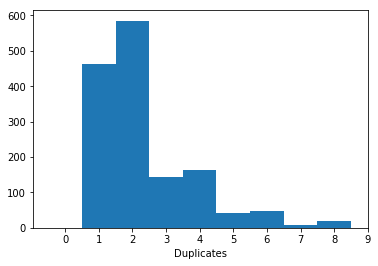

In [4]:
u, c = np.unique(batch.index.get_df()['offset'], return_counts=True)
plt.hist(c, bins = -0.5 + np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel('Duplicates')
plt.show()

In [17]:
batch = batch.crop(src=('raw', 'lift'), dst=('raw', 'lift'), origin=10, shape=(32, 256))

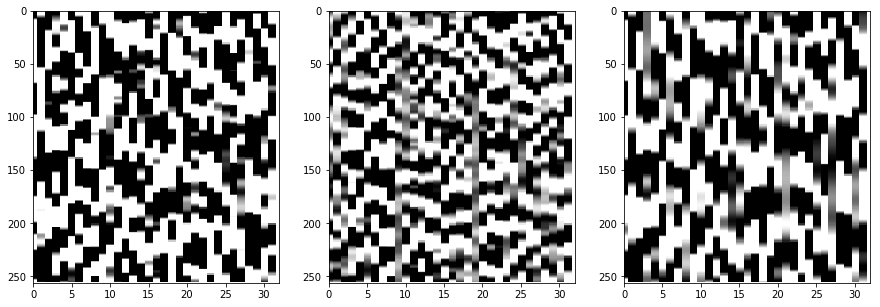

In [18]:
j = 8
seismic_plot([batch.raw[0][j], batch.lift[0][j], batch.raw[0][j] - batch.lift[0][j]],
             figsize=(15, 5), vmin=-cv, vmax=cv, cmap='gray')

Selecting field records and traces for model training:

In [4]:
train_index = index.create_subset(index.indices[:10])

train_index = train_index.filter('offset', lambda x: x < 2000)
train_set = SeismicDataset(train_index)

## Model architecture

We exploit a convolutional neural network of the U-net type with depth 4 and the following config:

Layouts:
* encoder: Conv2d - Activation - Conv2d - Activation
* downsampling: MaxPooling1d - Dropout
* decoder: Conv2d - Activation - Conv2d - Activation
* upsampling: TransposedConv1d - Activation - Dropout

Convolutions (Conv1d, TransposedConv1d):
* ```filters``` = 16 * 2**i, i is a encoder (decoder) depth level, varies from 0 to 3.
* ```kernel_size``` = (5, 5)
* ```strides``` = (2, 2)
* ```padding``` = ```'same'```
* ```data_format``` = ```'channels_last'```
* ```activation``` = None

MaxPooling1d:
* ```pool_size``` = (2, 2)
* ```pool_strides``` = (1, 1).

Activation:
* ```activation``` = ```tf.nn.elu```

Dropout:
* ```dropout_rate```=0.05

Setting the model config:

In [5]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (None, None, 1)}, 
                   y={'name':'targets', 'shape': (None, None, 1)}),
    'loss': 'l1',
    'optimizer': ('Adam', {'learning_rate': 0.0001}),
    'body': {'main': {
                    'encoder/num_stages': 4,
                    'encoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128],
                                           kernel_size=(5, 5), momentum=0.9, 
                                           activation=tf.nn.elu),
                    'encoder/downsample': dict(layout='pd', pool_size=(2, 2),
                                               pool_strides=(2, 2), dropout_rate=0.05),

                    'decoder/num_stages': 4,
                    'decoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128][::-1],
                                           kernel_size=(5, 5), momentum=0.9, activation=tf.nn.elu),
                    'decoder/upsample': dict(layout='tad', kernel_size=(5, 5), strides=(2, 2),
                                     dropout_rate=0.05, activation=tf.nn.elu,),
                    }
                   }
}

## Hyperparameters estimation

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* premute traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.0001

Loss fuction: ```l1```

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 3.

Setting a train pipeline:

In [6]:
def exp_stack(x):
    return np.expand_dims(np.vstack([np.stack(arr) for arr in x]), -1)

def make_data_p(batch, **kwagrs):
    x = exp_stack(batch.raw)
    y = exp_stack(batch.lift)
    perm = np.random.permutation(np.arange(x.shape[1]))
    x = x[:, perm]
    y = y[:, perm]
    return {'x': x, 'y': y}

train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_variable('loss', default=list())
                  .init_model('dynamic', Unet, 'unet', model_config)
                  .crop(src=('raw', 'lift'), dst=('raw', 'lift'), origin=10, shape=(32, 256))
                  .train_model('unet', make_data=make_data_p,
                               fetches='loss', save_to=V('loss', mode='a'))
                 )

Run the training pipeline

In [7]:
batch_size = 2

train_pipeline = train_pipeline << train_set
train_pipeline.run(batch_size, n_epochs=500, drop_last=True, shuffle=True, bar=True)

100%|██████████| 2500/2500 [17:38<00:00,  2.36it/s]


Loss against iterations:

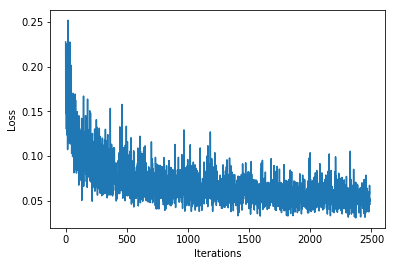

In [9]:
plt.plot(train_pipeline.get_variable("loss")[10:])
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

Dump the model:

In [10]:
train_pipeline.save_model_now('unet', './unet_2d_model_p')

## Model evaluation

Inference pipeline for model evaluation:

In [11]:
def make_data(batch, **kwagrs):
    x = np.expand_dims(np.stack(batch.raw), -1)
    return {'x': x}

def make_data_p(batch, **kwagrs):
    x = np.expand_dims(np.stack(batch.raw), -1)
#     tmp = x[:, ::2]
#     x[:, ::2] = x[:, 1::2]
#     x[:, 1::2] = tmp
    
    offsets = batch.index.get_df()['offset'].values
    u, c = np.unique(offsets, return_counts=True)
    x = np.expand_dims(np.stack(batch.raw), -1)
    dupl = u[c > 1]
    for v in dupl:
        pos = np.where(offsets == v)[0]
        x[:, pos] = x[:, pos[::-1]]
    return {'x': x}

def get_offset(batch, *args, **kwargs):
    return batch.index.get_df()['offset'].values

predict_pipeline = (Pipeline()
                    .import_model('unet', train_pipeline)
                    .init_variable('res', default=list())
                    .init_variable('res_p', default=list())
                    .init_variable('raw', default=list())
                    .init_variable('lift', default=list())
                    .init_variable('offset', default=list())
                    .load(components=('raw', 'lift'), tslice=np.arange(3000),
                          fmt='segy')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .call(get_offset, B(), save_to=V('offset', mode='a'))
                    .predict_model('unet', fetches='out_lift', make_data=make_data,
                                   save_to=V('res', mode='a'))
                    .predict_model('unet', fetches='out_lift', make_data=make_data_p,
                                   save_to=V('res_p', mode='a'))
                   )

Select a sample seismogram from test part of the dataset:

In [12]:
i = 29
# test_set = SeismicDataset(train_index.create_subset(train_index.indices[i: i+1]))
test_set = SeismicDataset(index.create_subset(index.indices[i: i+1]))

Run the inference pipeline on the test seismograms:

In [13]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=1, n_epochs=1, drop_last=False, shuffle=False, bar=True)

100%|██████████| 1/1 [00:14<00:00, 14.21s/it]


Arrange results:

In [14]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=(0, -1))
res_p = np.squeeze(np.vstack(predict_pipeline.get_variable("res_p")), axis=(0, -1))
offsets = predict_pipeline.get_variable("offset")[0]
raw = np.vstack(np.concatenate(predict_pipeline.get_variable("raw")))
lift = np.vstack(np.concatenate(predict_pipeline.get_variable("lift")))

# tmp = res_p[:, ::2]
# res_p[:, ::2] = res_p[:, 1::2]
# res_p[:, 1::2] = tmp

u, c = np.unique(offsets, return_counts=True)
dupl = u[c > 1]
for v in dupl:
    pos = np.where(offsets == v)[0]
    res_p[pos] = res_p[pos[::-1]]

### Visual estimation

Show model output, permuted model output and difference between them:

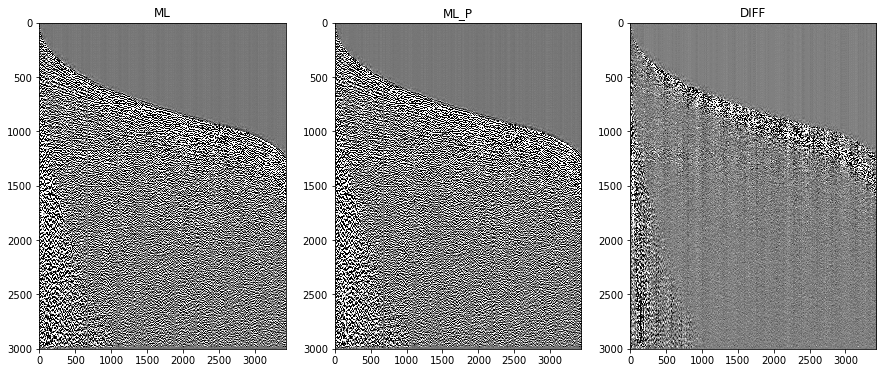

In [15]:
cv = 0.1
seismic_plot([res, res_p, res - res_p], names=['ML', 'ML_P', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Show raw traces, model output and difference between them:

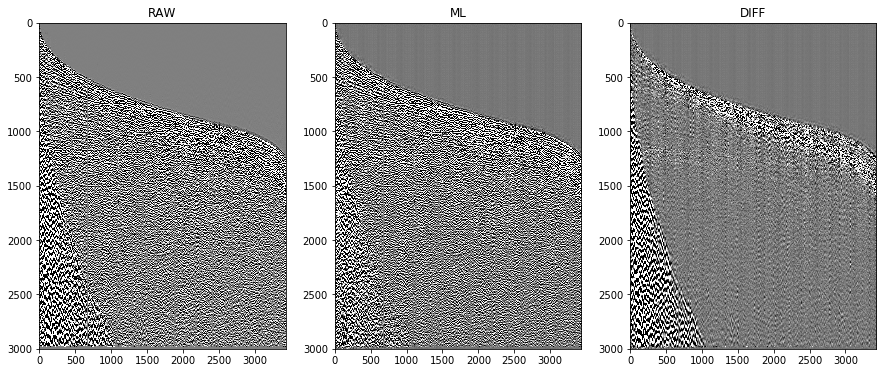

In [18]:
cv = 0.1
seismic_plot([raw, res, res - raw], names=['RAW', 'ML', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

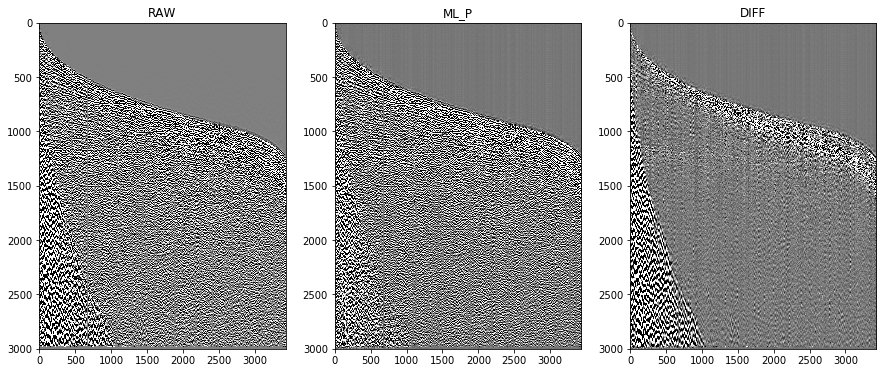

In [19]:
cv = 0.1
seismic_plot([raw, res_p, res_p - raw], names=['RAW', 'ML_P', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Show model output, traget seismogram difference between them:

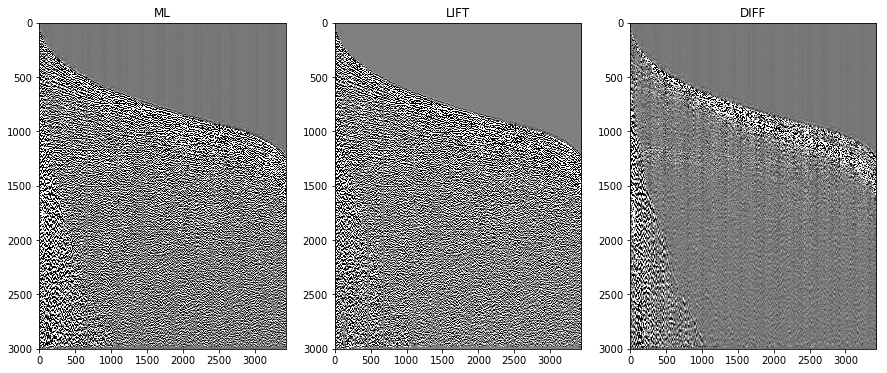

In [20]:
seismic_plot([res, lift, res - lift], names=['ML', 'LIFT', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

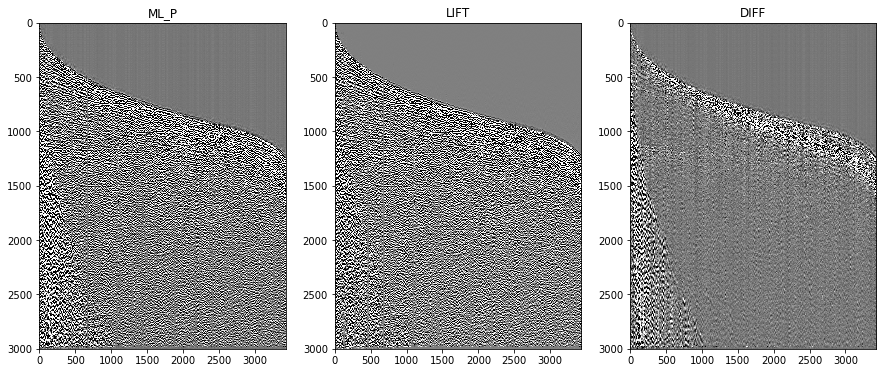

In [21]:
seismic_plot([res_p, lift, res_p - lift], names=['ML_P', 'LIFT', 'DIFF'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

### MAE metrics

Estimate MAE between model output and target seismogram:

In [22]:
mtr = FieldMetrics(lift, res)
mtr_p = FieldMetrics(lift, res_p)
print('MAE:', mtr.mae(), mtr_p.mae())

MAE: 0.026665568 0.026671307


### Trace correlations

Get correlation coeffitiens between target traces and model output:

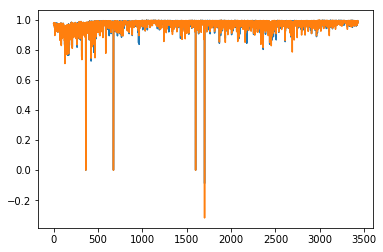

In [24]:
corr = mtr.corr_coef(reduce=None)
plt.plot(corr)
corr_p = mtr_p.corr_coef(reduce=None)
plt.plot(corr_p)
plt.show()

Note that zero correlation occurs due to zero traces in the dataset.

Average correlation is:

In [25]:
print('Averaged correlation:', mtr.corr_coef(), mtr_p.corr_coef())

Averaged correlation: 0.9732077 0.9729301


### Power spectrum comparison

Power spectrum comparison in the gourd roll area:

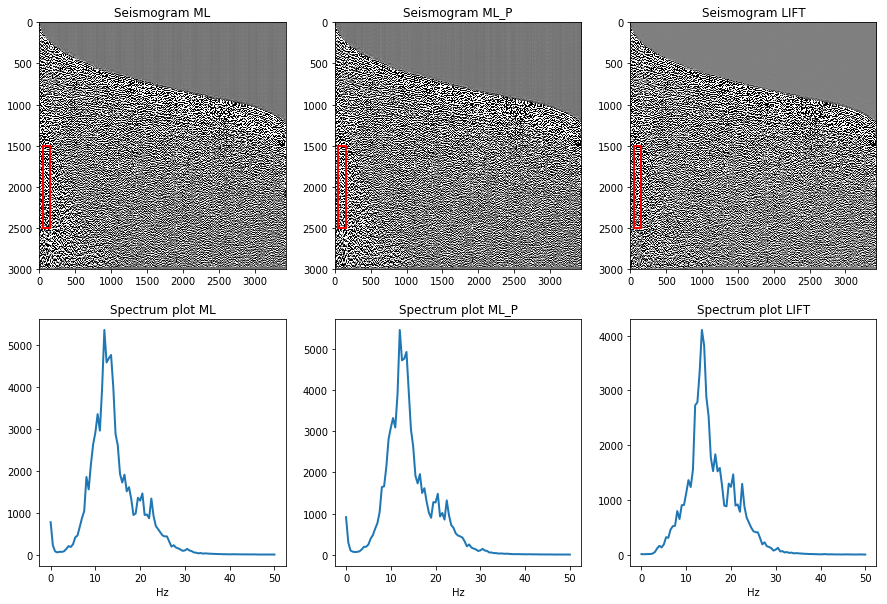

In [26]:
spectrum_plot([res, res_p, lift], frame=(slice(50, 150), slice(1500, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['ML', 'ML_P', 'LIFT'])

Power spectrum comparison out of ground-roll region:

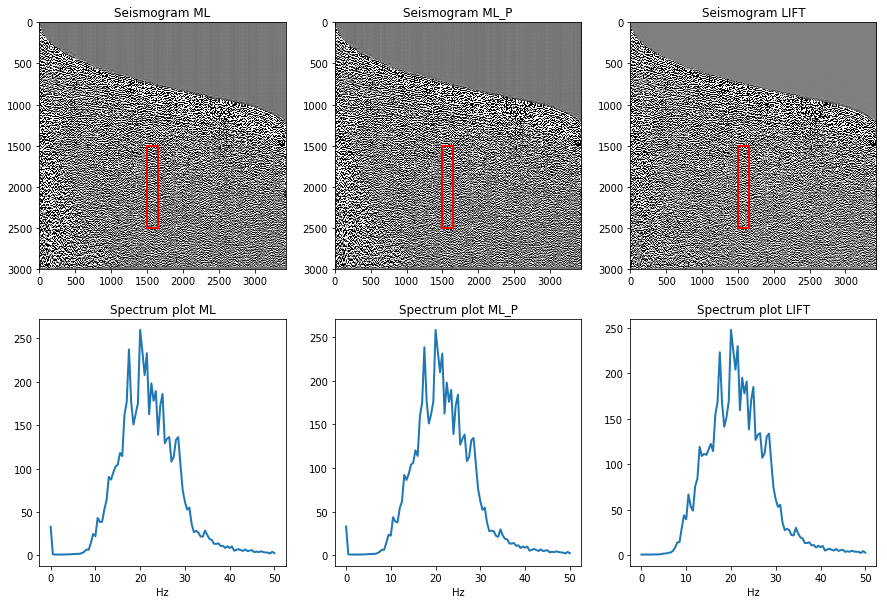

In [27]:
spectrum_plot([res, res_p, lift], frame=(slice(1500, 1650), slice(1500, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['ML', 'ML_P', 'LIFT'])

### Trace statistics comparison

Comparison of rms amplitudes:

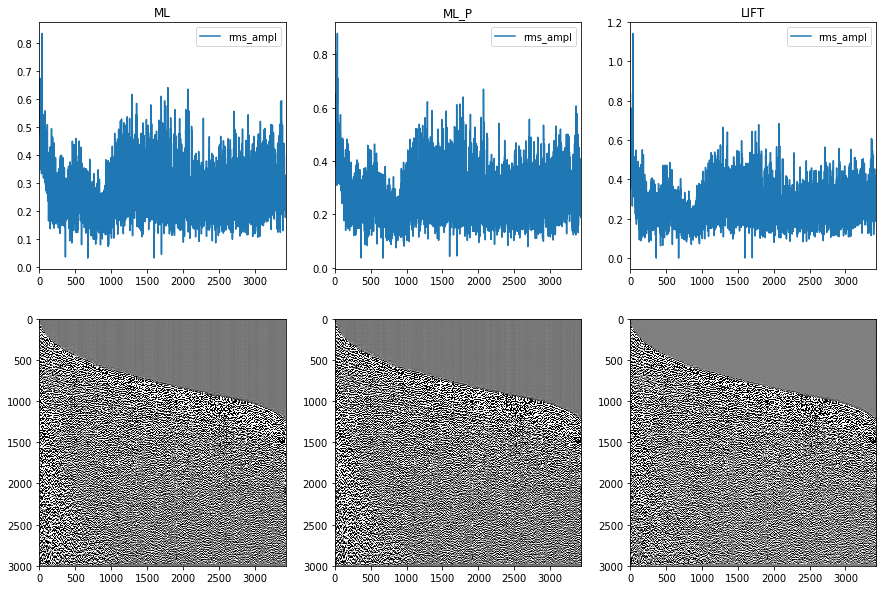

In [28]:
statistics_plot((res, res_p, lift), stats='rms_ampl', names=['ML', 'ML_P', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

Comparison of rms frequencies:

../../../seismicpro/src/plot_utils.py:318: RuntimeWarning: invalid value encountered in true_divide
  spec = spec / spec.sum(axis=1).reshape((-1, 1))


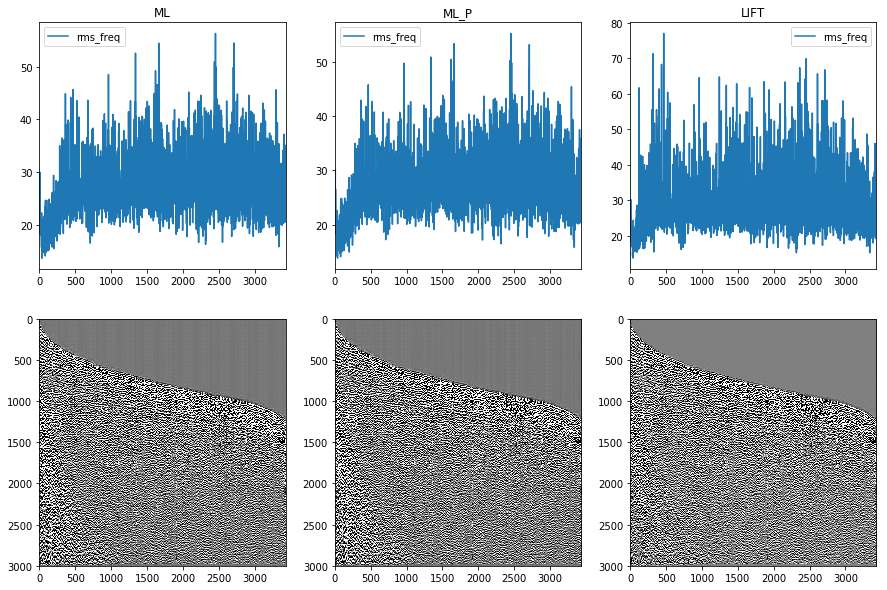

In [29]:
statistics_plot((res, res_p, lift), stats='rms_freq', rate=0.002,
                names=['ML', 'ML_P', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

## Criticism

## Conclusion

## Suggestions for improvements